In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from google.cloud import storage

# Initialize the random number generator
import random
np.random.seed(100)
import re

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import gensim

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

#from nltk.chat.util import Chat, reflections

#import json
#import pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Dense,SpatialDropout1D
from keras.optimizers import SGD, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant



[nltk_data] Downloading package punkt to
[nltk_data]     /home/test_drive_25_09_1976/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/test_drive_25_09_1976/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/test_drive_25_09_1976/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/test_drive_25_09_1976/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-01-25 01:02:10.928160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Function to download specified file extension from given Google cloud location to this VM.

def downloadSpecificFile(bucket, path, fileExtension):
    fileNameList = []
    blobs = bucket.list_blobs(prefix = path, delimiter = '/')
    for blob in blobs:
        if(blob.name != path):
            fullName = blob.name
            res = fullName.find(fileExtension)
            if (res >= 0):
                file_name = blob.name.replace(path, "")
                blob.download_to_filename(file_name) # download the file to the machine
                fileNameList.append(file_name)
    return fileNameList

In [3]:
# Set the bucket name from Google cloud where train & test data files are loaded.

bucket_name = 'aiml_gl2'
storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

In [4]:
root = 'CapstoneProject/ChatBot/'

In [5]:
# Code which invokes downloadSpecificFile method which would help in reading 
# the npy file which contains images in matrix format & its mask information

fileNameList = downloadSpecificFile(bucket, root, '.csv')
gloveFileList = downloadSpecificFile(bucket, root, '.txt')

In [6]:
dataFile = fileNameList[0]
gloveFile = gloveFileList[0]

# Using Panda to read csv file
df = pd.read_csv(dataFile)

df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,1/1/2016 0:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,1/6/2016 0:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,1/8/2016 0:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,1/10/2016 0:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [7]:
df.shape

(425, 11)

### Observation:-
- There are 425 records in data & 11 columns

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


### Observation:-
- Info method displays the metadata of columns.
- Unnamed column ie Serial number is of datatype integer.
- Rest of the columns have datatype of object.

### Null value check

In [9]:
df.isnull().sum()

Unnamed: 0                  0
Data                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Genre                       0
Employee or Third Party     0
Critical Risk               0
Description                 0
dtype: int64

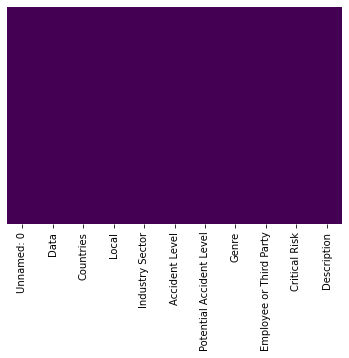

In [10]:
# Plotting HeatMap to display null value (Visualization)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

### Observation:-
- From HeatMap we conclude that there are no null or nan values provided in data.

### Removing New line character from data

In [11]:
# Replace method which would replace new line character with empty space.

df = df.replace('\n', '', regex=True)

In [12]:
df['Desc_count'] = df['Description'].apply(lambda x: len(x))

In [13]:
df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Desc_count
0,0,1/1/2016 0:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,457
1,1,1/2/2016 0:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,307
2,2,1/6/2016 0:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,314
3,3,1/8/2016 0:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,562
4,4,1/10/2016 0:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,487


### Univariate Analysis

In [14]:
df['Potential Accident Level'].value_counts()

IV     143
III    106
II      95
I       49
V       31
VI       1
Name: Potential Accident Level, dtype: int64

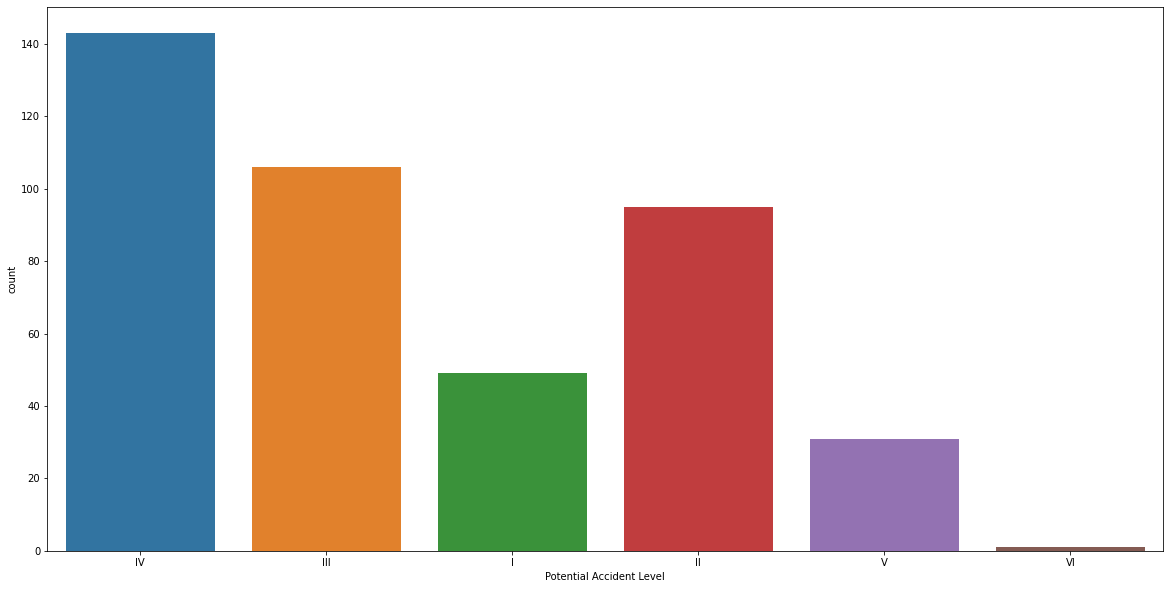

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Potential Accident Level', ax=ax);

### Observation:-
- The dataset provided here is imbalanced.
- Potential Accident Level IV has highest number of records ie 143.
- Potential Accident Level III has second highest number of records ie 106.
- Potential Accident Level II has third highest number of records ie 95.
- Potential Accident Level VI has lowest number of records ie 1.

In [16]:
df['Genre'].value_counts()

Male      403
Female     22
Name: Genre, dtype: int64

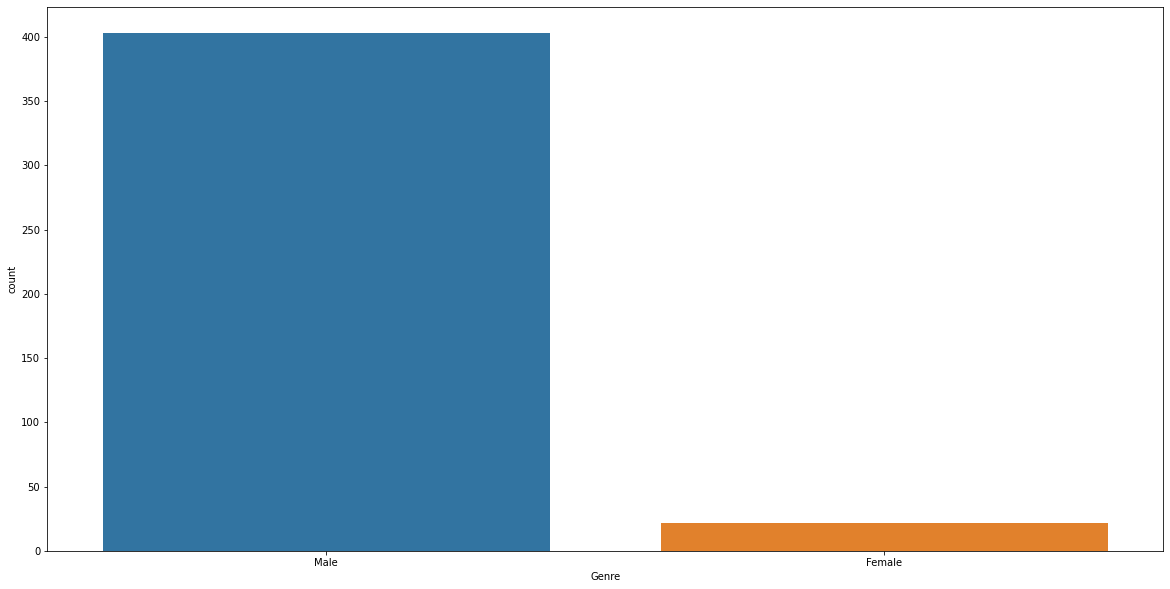

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Genre', ax=ax);

### Observation:-
- Under Genre there are 2 categories - Male & Female.
- In dataset, Male population is higher than Females.
- Male population is 403 which is 94.82% in that category.
- Female population is 22 which is 5.18% in that category.

In [16]:
df['Employee or Third Party'].value_counts()

Third Party             189
Employee                179
Third Party (Remote)     57
Name: Employee or Third Party, dtype: int64

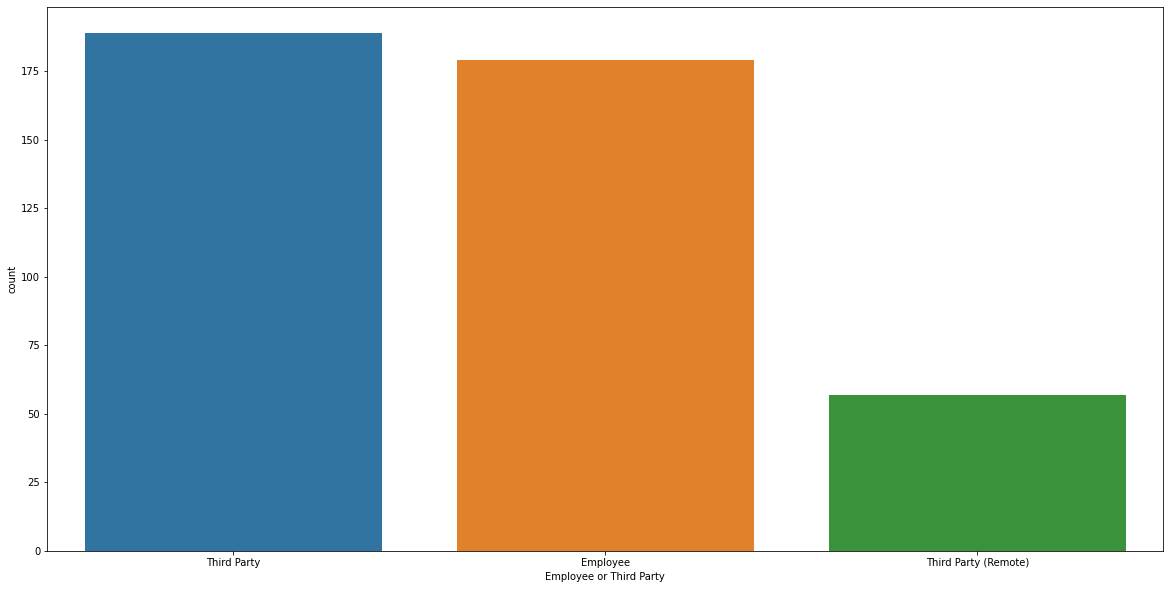

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Employee or Third Party', ax=ax);

### Observation:-
- Under Employee or Third Party column there are 3 categories - Third Party, Employee & Third Party (Remote).
- In dataset, Third Party category is highest - 189 which is 44.47% in that category.
- Employee category is second highest - 179 which is 42.12% in that category.
- Third Party (Remote) category is third highest - 57 which is 13.41% in that category.

In [20]:
df['Critical Risk'].value_counts()

Others                                       232
Pressed                                       24
Manual Tools                                  20
Chemical substances                           17
Venomous Animals                              16
Cut                                           14
Projection                                    13
Bees                                          10
Fall                                           9
Vehicles and Mobile Equipment                  8
Fall prevention (same level)                   7
remains of choco                               7
Pressurized Systems                            7
Fall prevention                                6
Suspended Loads                                6
Blocking and isolation of energies             3
Pressurized Systems / Chemical Substances      3
Power lock                                     3
Liquid Metal                                   3
Projection of fragments                        2
Machine Protection  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 [Text(0, 0, 'Pressed'),
  Text(1, 0, 'Pressurized Systems'),
  Text(2, 0, 'Manual Tools'),
  Text(3, 0, 'Others'),
  Text(4, 0, 'Fall prevention (same level)'),
  Text(5, 0, 'Chemical substances'),
  Text(6, 0, 'Liquid Metal'),
  Text(7, 0, 'Electrical installation'),
  Text(8, 0, 'Confined space'),
  Text(9, 0, 'Pressurized Systems / Chemical Substances'),
  Text(10, 0, 'Blocking and isolation of energies'),
  Text(11, 0, 'Suspended Loads'),
  Text(12, 0, 'Poll'),
  Text(13, 0, 'Cut'),
  Text(14, 0, 'Fall'),
  Text(15, 0, 'Bees'),
  Text(16, 0, 'Fall prevention'),
  Text(17, 0, 'Not applicable'),
  Text(18, 0, 'Traffic'),
  Text(19, 0, 'Projection'),
  Text(20, 0, 'Venomous Animals'),
  Text(21, 0, 'Plates'),
  Text(22, 0, 'Projection/Burning'),
  Text(23, 0, 'remains of choco'),
  Text(24, 0, 'Vehicles and Mobile Equipment'),
  Text(25

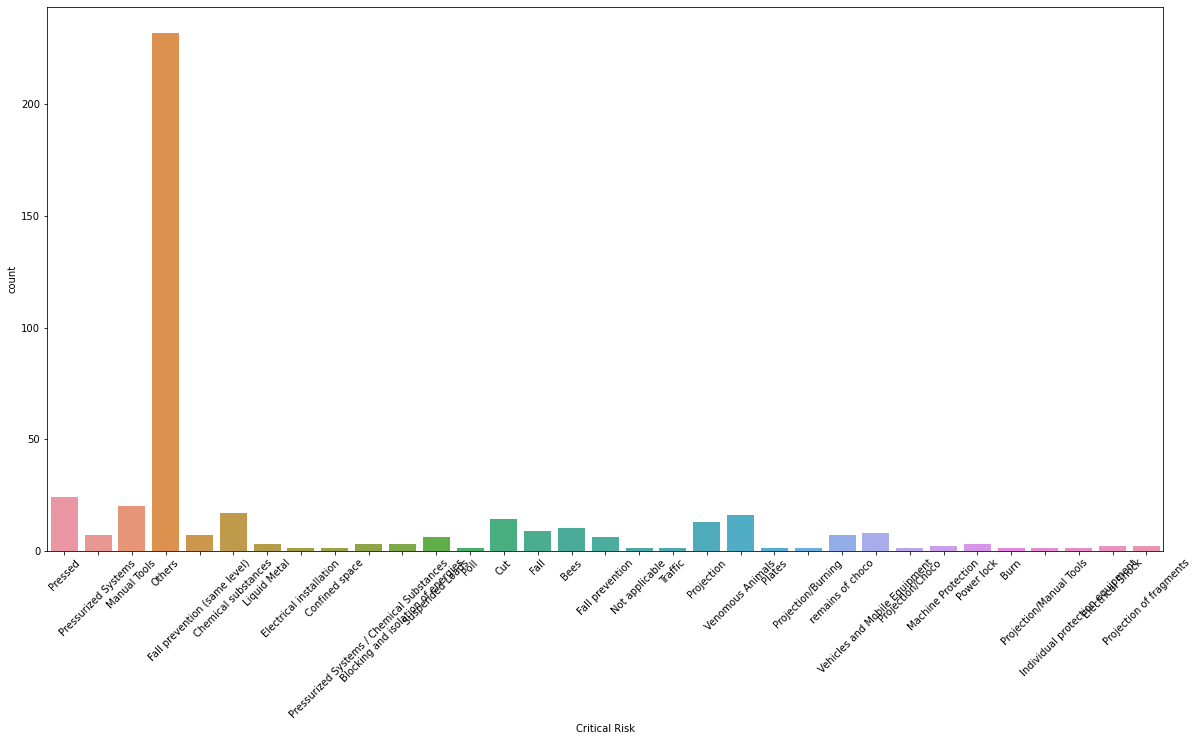

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Critical Risk', ax=ax);
plt.xticks(rotation=45)

### Observation:-
- Under Critical Risk column there are 33 categories - 
  - Pressed.
  - Manual Tools
  - Chemical substances
  - Venomous Animals
  - Cut
  - Projection
  - Bees
  - Fall
  - Vehicles and Mobile Equipment
  - Fall prevention (same level)
  - remains of choco
  - Pressurized Systems
  - Fall prevention
  - Suspended Loads
  - Blocking and isolation of energies
  - Pressurized Systems / Chemical Substances
  - Power lock
  - Liquid Metal, Projection of fragments
  - Machine Protection
  - Electrical Shock
  - Individual protection equipment
  - Projection/Manual Tools
  - Burn
  - Poll
  - Projection/Choco
  - Projection/Burning
  - Plates
  - Confined space
  - Traffic
  - Not applicable
  - Electrical installation
  - Others
- In dataset, Others category is highest - 232 which is 54.59% in that category.
- Pressed is second highest - 24 which is 5.65% in that category.
- Manual Tools category is third highest - 20 which is 4.71% in that category.

In [22]:
df['Desc_count'].describe()

count     425.000000
mean      368.280000
std       178.944426
min        94.000000
25%       227.000000
50%       335.000000
75%       457.000000
max      1029.000000
Name: Desc_count, dtype: float64

### Observation:-
- In dataset we have Description column, a new column called Desc_count has been added based on Description column.
- Desc_count contains total character count under Description for each record.
- We have used describe function on this Desc_count column which shows various statistics.
    - There total 425 records.
    - The mean of Desc_count column is 368.28
    - Standard deviation is 178.94 for Desc_count column.
    - The minimum description length is 94 characters.
    - The maximum description length is 1029 characters.

In [18]:
df['Desc_count'].value_counts()

410     4
358     4
331     4
142     3
334     3
198     3
484     3
352     3
307     3
403     3
384     3
323     3
514     3
206     3
415     3
251     3
726     3
382     3
288     3
355     3
453     3
634     3
622     3
391     2
342     2
511     2
304     2
267     2
152     2
722     2
194     2
224     2
308     2
227     2
356     2
438     2
208     2
443     2
191     2
164     2
201     2
220     2
363     2
413     2
328     2
310     2
168     2
250     2
485     2
239     2
586     2
223     2
210     2
335     2
157     2
447     2
215     2
266     2
272     2
298     2
178     2
437     2
804     2
319     2
116     2
295     2
236     2
362     2
219     2
312     2
203     2
369     2
611     2
230     2
225     2
281     2
633     2
904     2
145     2
431     2
174     2
144     2
315     2
217     2
247     2
303     2
364     2
317     2
474     2
234     2
324     2
349     2
487     2
123     2
404     2
255     2
222     2
314     2
717     1
139     1


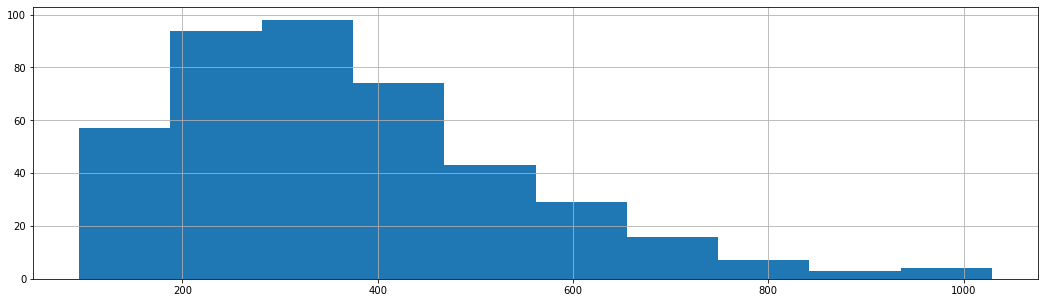

In [23]:
df['Desc_count'].hist(stacked=False, figsize=(18,5)); 

### Observation:-

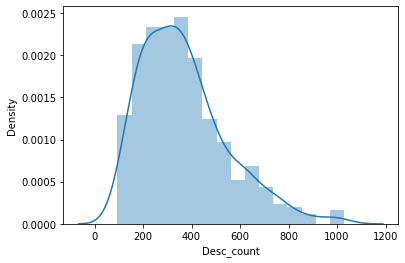

In [24]:
sns.distplot(df['Desc_count']);
plt.show()

### Observation:-
- Above is distribution plot or Guassian curve for Desc_count.
- The curve is not exactly bell shaped & is skewed.
- The curve is more skewed on right side whereas on left side its steep.

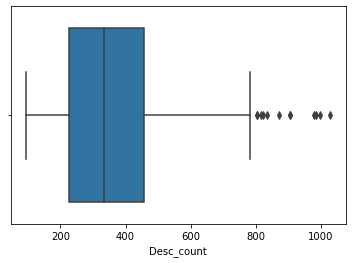

In [25]:
sns.boxplot(x=df['Desc_count']);
plt.show()

### Observation:-
- Desc_count column has outliers near max whisker. There are more number of data between 75% & Max whisker as compared to 25% & min whisker. Also there are more number of data between 50% & 75% points.

### Bivariate Analysis

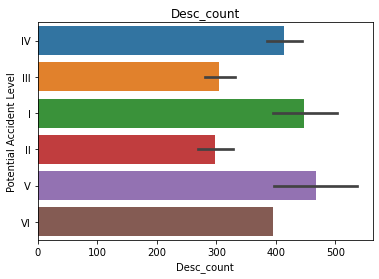

In [26]:
sns.barplot(x='Desc_count', y='Potential Accident Level', data=df);
plt.xlabel('Desc_count')
plt.ylabel('Potential Accident Level')
plt.title('Desc_count')
plt.show()

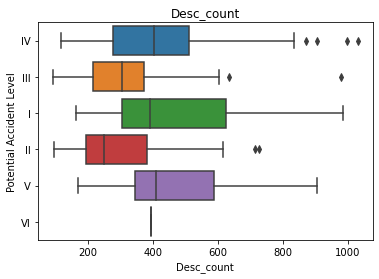

In [27]:
sns.boxplot(x='Desc_count', y='Potential Accident Level', data=df);
plt.xlabel('Desc_count')
plt.ylabel('Potential Accident Level')
plt.title('Desc_count')
plt.show()

In [51]:
# Potential Accident Level VI has only 1 record which would be of no use hence dropping that record.
df.drop([307], inplace = True)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Desc_count


In [52]:
df['Potential Accident Level'].value_counts()

IV     143
III    105
II      95
I       49
V       31
Name: Potential Accident Level, dtype: int64

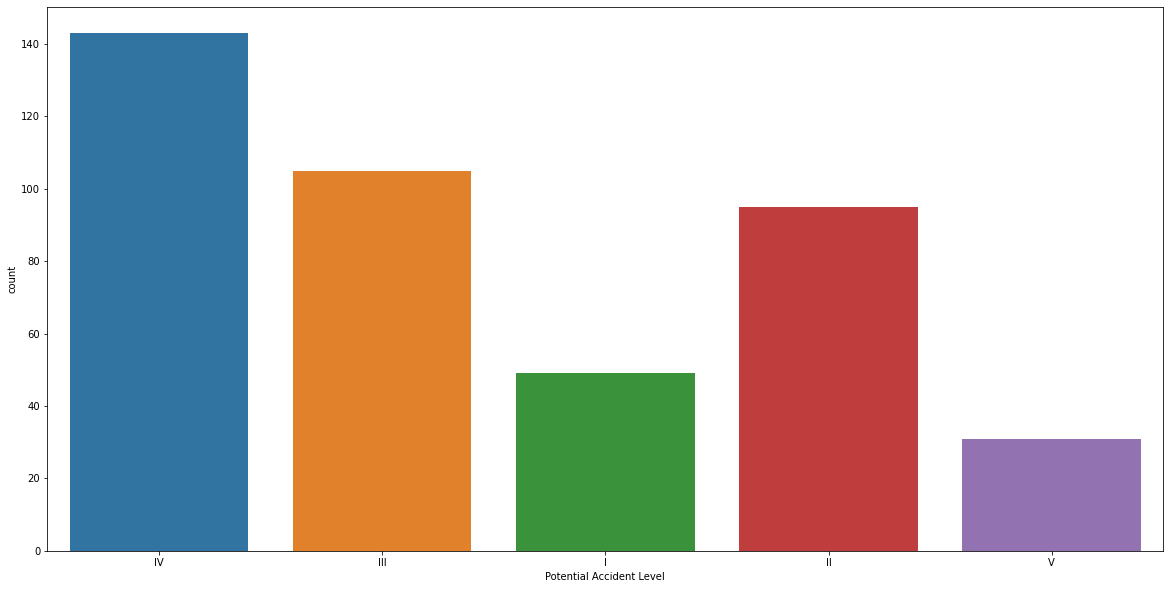

In [53]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Potential Accident Level', ax=ax);

In [55]:
df.drop(['Unnamed: 0', 'Data', 'Countries', 'Local', 'Industry Sector', 'Accident Level', 'Genre', 'Employee or Third Party', 'Critical Risk', 'Desc_count'], axis=1, inplace=True)

In [57]:
X = df ## Predicted dataset
y = df['Potential Accident Level'] ## Target attribute

In [58]:
X

,Potential Accident Level,Description
0,IV,While removing the drill rod of the Jumbo 08 f...
1,IV,During the activation of a sodium sulphide pum...
2,III,In the sub-station MILPO located at level +170...
3,I,Being 9:45 am. approximately in the Nv. 1880 C...
4,IV,Approximately at 11:45 a.m. in circumstances t...
5,III,During the unloading operation of the ustulado...
6,III,The collaborator reports that he was on street...
7,III,"At approximately 04:50 p.m., when the mechanic..."
8,IV,Employee was sitting in the resting area at le...
9,II,At the moment the forklift operator went to ma...


In [59]:
y

0       IV
1       IV
2      III
3        I
4       IV
5      III
6      III
7      III
8       IV
9       II
10     III
11      IV
12       I
13       V
14     III
15      IV
16      IV
17      II
18      II
19     III
20      II
21      IV
22      IV
23      II
24      II
25      II
26       I
27     III
28      IV
29     III
30      II
31      II
32      IV
33       V
34      II
35     III
36      IV
37       V
38       V
39      IV
40      IV
41      IV
42     III
43     III
44     III
45     III
46     III
47      IV
48     III
49      IV
50      IV
51       V
52       V
53      IV
54      IV
55     III
56     III
57      II
58      II
59      II
60      II
61      IV
62     III
63      IV
64      IV
65      IV
66      II
67      IV
68      IV
69      IV
70     III
71     III
72     III
73     III
74       V
75     III
76       V
77       V
78      II
79      IV
80       I
81      II
82      IV
83     III
84     III
85      II
86      IV
87      IV
88      IV
89     III
90      II

In [60]:
# Train Test spilt with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

In [61]:
X_train

,Potential Accident Level,Description
358,V,Being approximately 20:57 hours of 03/22/2017;...
60,II,"The employee, when performing the adjustment /..."
161,IV,In plant while doing work on GEHO pump reducer...
370,IV,In the tower N ° 6 of the old 50 KV LT (disabl...
150,I,The Safety and Technical moved to the field fo...
216,IV,Employee reports that he was monitoring the ex...
247,IV,In the activity of placing boards on racks for...
47,IV,The locomotive No. 15 operated by MAPERU perso...
275,II,The maid while walking in the electrolysis are...
424,II,"At 10:00 a.m., when the assistant cleaned the ..."


In [62]:
X_train.shape

(296, 2)

In [63]:
X_train['Potential Accident Level'].value_counts()

IV     104
III     71
II      67
I       31
V       23
Name: Potential Accident Level, dtype: int64

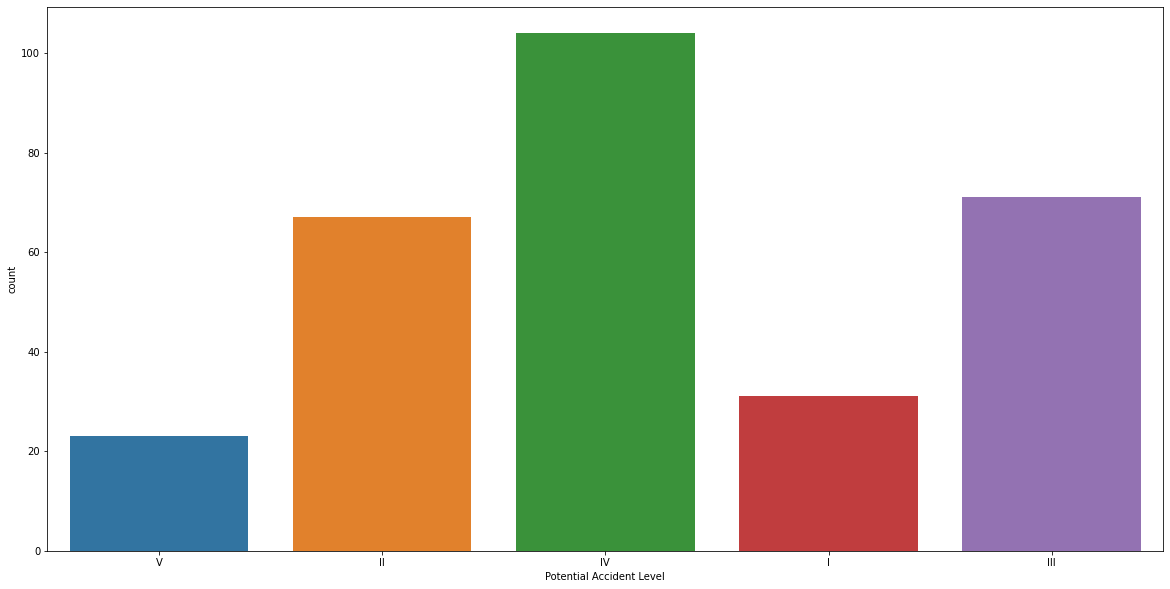

In [64]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=X_train, x='Potential Accident Level', ax=ax);

In [80]:
X_Pal_I   = X_train[X_train['Potential Accident Level'] == 'I']
X_Pal_II  = X_train[X_train['Potential Accident Level'] == 'II']
X_Pal_III = X_train[X_train['Potential Accident Level'] == 'III']
X_Pal_IV  = X_train[X_train['Potential Accident Level'] == 'IV']
X_Pal_V   = X_train[X_train['Potential Accident Level'] == 'V']

In [81]:
# model_type: glove
aug_w2v = naw.WordEmbsAug(model_type='glove', model_path=gloveFile, action="substitute")

In [82]:
X_Pal_I_Sample_Df   = X_Pal_I.sample(n=75, replace=True)
X_Pal_II_Sample_Df  = X_Pal_II.sample(n=40, replace=True)
X_Pal_III_Sample_Df = X_Pal_III.sample(n=30, replace=True)
X_Pal_V_Sample_Df   = X_Pal_V.sample(n=80, replace=True)

In [83]:
def augmentText(pal_df):
    for i, row in pal_df.iterrows():
        pal_df.at[i, 'Description'] = aug_w2v.augment(row['Description'])

In [84]:
augmentText(X_Pal_I_Sample_Df)
augmentText(X_Pal_II_Sample_Df)
augmentText(X_Pal_III_Sample_Df)
augmentText(X_Pal_V_Sample_Df)

In [90]:
frames = [X_train, X_Pal_I_Sample_Df, X_Pal_II_Sample_Df, X_Pal_III_Sample_Df, X_Pal_V_Sample_Df]
X_train_bal = pd.concat(frames)

In [91]:
X_train_bal.shape

(521, 2)

In [92]:
X_train_bal['Potential Accident Level'].value_counts()

II     107
I      106
IV     104
V      103
III    101
Name: Potential Accident Level, dtype: int64

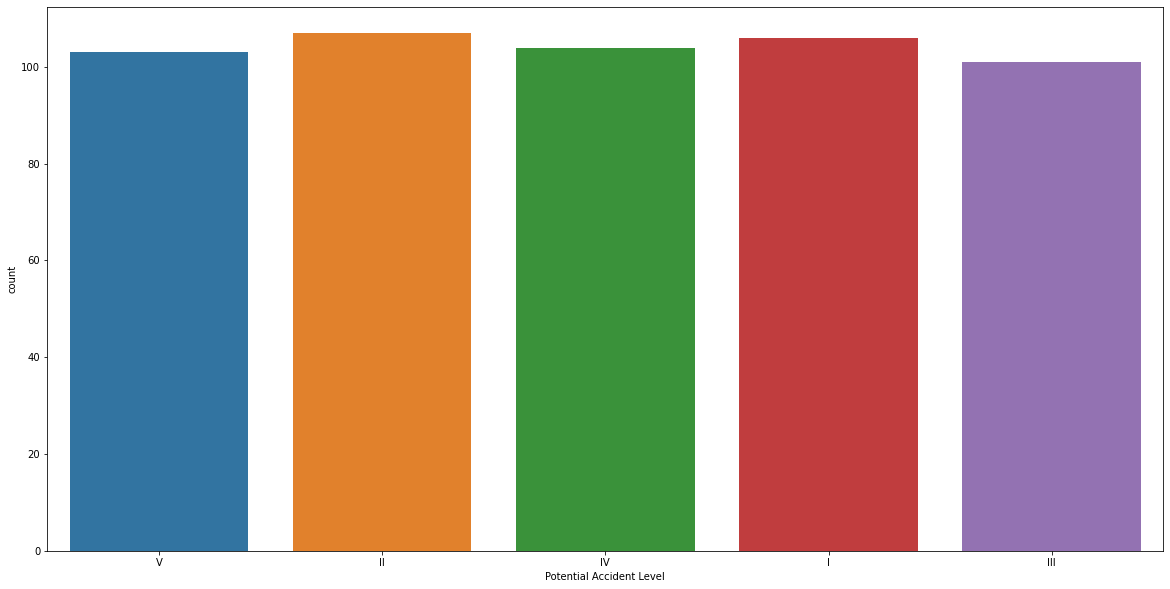

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(data=X_train_bal, x='Potential Accident Level', ax=ax);

In [94]:
y_train_bal = X_train_bal['Potential Accident Level']

In [95]:
y_train_bal.shape

(521,)

In [96]:
X_train_bal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 358 to 52
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Potential Accident Level  521 non-null    object
 1   Description               521 non-null    object
dtypes: object(2)
memory usage: 28.4+ KB


In [97]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 136 to 15
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Potential Accident Level  127 non-null    object
 1   Description               127 non-null    object
dtypes: object(2)
memory usage: 3.0+ KB


In [98]:
X_train_bal.drop(['Potential Accident Level'], axis=1, inplace=True)

In [99]:
X_test.drop(['Potential Accident Level'], axis=1, inplace=True)

In [100]:
# displaying Description data from text column for 1st row
X_train_bal['Description'][0]

'While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.'

In [103]:
# displaying Description data from text column for 1st row
X_test['Description'][136]

'During the field trip, on LT 01 of the Lajes target, Junior da Costa official stepped on a wooden stump that was on the ground, approximately 5 cm, which pierced his boot wounding the sole of the right foot. At the time of the accident, the employee was using all the PPE required for the activity and had his hands free. The employee was taken to the hospital, where he went through medical care, and was released to return to his activities the next day of work.'

In [104]:
# Replaces extra spaces between words with single space
X_train_bal['Clean_Desc'] = X_train_bal['Description'].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))
X_test['Clean_Desc'] = X_test['Description'].apply(lambda x: re.sub(r'[^A-Za-z]+', ' ', x))

In [105]:
X_train_bal['Clean_Desc'][0]

'While removing the drill rod of the Jumbo for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo '

In [106]:
# displaying Description data from text column for 1st row
X_test['Clean_Desc'][136]

'During the field trip on LT of the Lajes target Junior da Costa official stepped on a wooden stump that was on the ground approximately cm which pierced his boot wounding the sole of the right foot At the time of the accident the employee was using all the PPE required for the activity and had his hands free The employee was taken to the hospital where he went through medical care and was released to return to his activities the next day of work '

In [107]:
# Changes text to lowercase
X_train_bal['Clean_Desc'] = X_train_bal['Clean_Desc'].apply(lambda x: x.lower())
X_test['Clean_Desc'] = X_test['Clean_Desc'].apply(lambda x: x.lower())

In [108]:
X_train_bal['Clean_Desc'][0]

'while removing the drill rod of the jumbo for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo '

In [109]:
X_test['Clean_Desc'][136]

'during the field trip on lt of the lajes target junior da costa official stepped on a wooden stump that was on the ground approximately cm which pierced his boot wounding the sole of the right foot at the time of the accident the employee was using all the ppe required for the activity and had his hands free the employee was taken to the hospital where he went through medical care and was released to return to his activities the next day of work '

In [110]:
# Remove spaces at the beginning and at the end of the string
X_train_bal['Clean_Desc'] = X_train_bal['Clean_Desc'].apply(lambda x: x.strip())
X_test['Clean_Desc'] = X_test['Clean_Desc'].apply(lambda x: x.strip())

In [111]:
X_train_bal['Clean_Desc'][0]

'while removing the drill rod of the jumbo for maintenance the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo'

In [112]:
X_test['Clean_Desc'][136]

'during the field trip on lt of the lajes target junior da costa official stepped on a wooden stump that was on the ground approximately cm which pierced his boot wounding the sole of the right foot at the time of the accident the employee was using all the ppe required for the activity and had his hands free the employee was taken to the hospital where he went through medical care and was released to return to his activities the next day of work'

In [113]:
# Remove stopwords
X_train_bal['Clean_Desc'] = X_train_bal['Clean_Desc'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))
X_test['Clean_Desc'] = X_test['Clean_Desc'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

In [114]:
X_train_bal['Clean_Desc'][0]

'removing drill rod jumbo maintenance supervisor proceeds loosen support intermediate centralizer facilitate removal seeing mechanic supports one end drill equipment pull hands bar accelerate removal moment bar slides point support tightens fingers mechanic drilling bar beam jumbo'

In [115]:
X_test['Clean_Desc'][136]

'field trip lt lajes target junior da costa official stepped wooden stump ground approximately cm pierced boot wounding sole right foot time accident employee using ppe required activity hands free employee taken hospital went medical care released return activities next day work'

In [116]:
X_train_bal.drop(['Description'], axis=1, inplace=True)
X_test.drop(['Description'], axis=1, inplace=True)

In [117]:
#X_train_No_Desc = X_train_bal.drop(['Clean_Desc'], axis=1)

In [118]:
#X_test_No_Desc = X_test.drop(['Clean_Desc'], axis=1)

In [119]:
#X_train_No_Desc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521 entries, 358 to 52
Empty DataFrame

In [120]:
# Perform PCA
#pca = PCA()
#pca.fit(X_train_No_Desc)

#X_train_pca = pca.transform(X_train_No_Desc)  # PCs for the train data
#X_test_pca = pca.transform(X_test_No_Desc)    # PCs for the test data

#X_train_pca.shape, X_test_pca.shape

In [121]:
#explained_variance = pca.explained_variance_ratio_
#explained_variance

In [120]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
X_train_tfidf = tfidfvectorizer.fit_transform(X_train_bal['Clean_Desc'])

In [121]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
tfidfvectorizer.get_feature_names()[:5]

['abandoned', 'abb', 'able', 'abratech', 'abrupt']

In [124]:
df_tfidfvect = pd.DataFrame(data = X_train_tfidf.toarray())
df_tfidfvect.shape

(624, 2727)

In [125]:
X_test_tfidf = tfidfvectorizer.fit_transform(X_test['Clean_Desc'])

In [126]:
X_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [127]:
df_tfidfvect_test = pd.DataFrame(data = X_test_tfidf.toarray())
df_tfidfvect_test.shape

(128, 1482)

In [131]:
X = X_train['Description']
y = y_train

In [132]:
X.head()

188    On leaving the Company the employee stumbled o...
15     The employee was working in the When a thermal...
60     The employee, when performing the adjustment /...
163    At 11:00 a.m., Mr. Frank with the support of a...
169    During execution of drilling on the target - B...
Name: Description, dtype: object

In [133]:
y

188    3
15     3
60     1
163    3
169    3
152    0
373    1
249    3
47     3
292    2
424    1
59     1
88     3
191    2
259    2
149    0
132    2
26     0
275    1
35     2
235    3
39     3
266    2
157    2
10     2
293    2
158    1
166    4
184    0
65     3
242    3
252    1
370    3
147    3
41     3
302    0
371    3
104    1
128    4
311    2
410    3
173    1
142    3
340    3
40     3
241    2
32     3
48     2
417    3
221    2
123    0
195    2
248    4
61     3
71     2
380    3
355    0
126    2
115    2
287    2
85     1
159    2
164    1
52     4
216    3
154    4
229    2
338    0
29     2
399    1
139    2
396    3
342    3
162    4
111    2
217    0
177    1
402    2
234    3
175    2
356    3
416    3
298    3
209    1
265    2
62     2
268    1
99     3
113    2
208    1
112    2
37     4
189    3
255    3
391    3
83     2
320    0
313    1
51     4
279    3
366    1
401    3
42     2
395    1
254    0
353    3
341    3
179    3
87     3
284    3
55     2
2

In [134]:
y.unique()

array([3, 1, 0, 2, 4, 5])

In [135]:
y.value_counts()

3    104
2     77
1     59
0     32
4     24
5      1
Name: Potential Accident Level, dtype: int64

In [135]:
# Initialize the variables
words=[]
ignore_words = ['?', '!']

# Tokenizing the words
for description in df['clean_Desc']:
    w = nltk.word_tokenize(description)
    words.extend(w)

In [136]:
# Lemmatizing the words
lemWords = [lemmatizer.lemmatize(w) for w in words if w not in ignore_words]
lemWords = sorted(list(set(lemWords)))